# Tutorial: Generative Models

## Wasserstein GANs
In this tutorial we will learn how to implement Wasserstein GANs (WGANs) using tensorflow.keras.

As example scenario we try to generate footprints of comsmic-ray induced airshowers, as for example measured by the Pierre Auger Observatory. This approach is a simplified version of: https://link.springer.com/article/10.1007/s41781-018-0008-x

### Software
First we have to import our software. Used versions:
- tf 2.4.0
- tf.keras 2.4.0
- np 1.19.5

In [1]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()  # gp loss won't work with eager
layers = keras.layers

print("tensorflow version", tf.__version__)
print("keras version", keras.__version__)
print("numpy version", np.__version__)

tensorflow version 2.8.0
keras version 2.8.0
numpy version 1.21.6


Let's now try to grab a GPU. A GPU is not needed but useful as it will heavily accelerate the training.

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found. If you use google colab, request a GPU via "Edit" --> "Notebook Settings"')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Data
To train our generative model we need some data. In this case we want to generate cosmic-ray induced air showers. The showers were simulated using https://doi.org/10.1016/j.astropartphys.2017.10.006

In [3]:
import gdown

url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1JfuYem6sXQSE3SYecHnNk5drtC7YKoYz"
output = 'airshowers.npz'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1JfuYem6sXQSE3SYecHnNk5drtC7YKoYz
To: /content/airshowers.npz
100%|██████████| 65.6M/65.6M [00:01<00:00, 64.8MB/s]


'airshowers.npz'

In [4]:
file = np.load(output)
shower_maps = file['shower_maps']
nsamples = len(shower_maps)

Now, we can have a look at some random footprints of the data set.

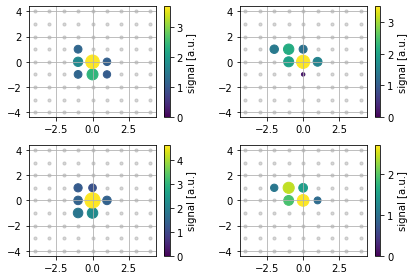

In [5]:
def rectangular_array(n=9):
    """ Return x,y coordinates for rectangular array with n^2 stations. """
    n0 = (n - 1) / 2
    return (np.mgrid[0:n, 0:n].astype(float) - n0)


for i,j in enumerate(np.random.choice(nsamples, 4)):
    plt.subplot(2,2,i+1)
    footprint=shower_maps[j,...,0]
    xd, yd = rectangular_array()
    mask = footprint != 0
    mask[5, 5] = True
    marker_size = 50 * footprint[mask]
    plot = plt.scatter(xd, yd, c='grey', s=10, alpha=0.3, label="silent")
    circles = plt.scatter(xd[mask], yd[mask], c=footprint[mask],
                           s=marker_size, alpha=1, label="loud")
    cbar = plt.colorbar(circles)
    cbar.set_label('signal [a.u.]')
    plt.grid(True)

plt.tight_layout()
plt.show()

## Wasserstein GANs
To overcome the meaningless loss and vanishing gradients, [Arjovsky, Chintala and Bottou](https://arxiv.org/abs/1701.07875) proposed to use Wasserstein-1 as a metric in the discriminator.

Using the Wasserstein distance as a metric has several advantages in comparison to the old min-max loss. The crucial feature of the Wasserstein distance is a meaningful distance measure even when distributions are disjunct. But before coming to the essential difference, let us try to understand the Wasserstein distance.

### Generator
For training GANs we need to further define our generator and discriminator network. We start by defining our generator network, which should map from our noise + label space into the space of images (latent-vector size --> image size). Adding the label the input of to both the generator and discriminator should enforce the generator to produce samples from the according class.

| Task |
|:-------------| 
|Design a meaningful generator model! Remember to check the latent and image dimensions. You can make use of the DCGAN guidelines.
Use a meaningful last activation function!|

In [6]:
def generator_model(latent_size):
    """ Generator network """
    latent = layers.Input(shape=(latent_size,), name="noise")
    z = layers.Dense(9 * 9 * latent_size)(latent)
    z = layers.Reshape((9, 9, latent_size))(z)
    z = layers.Conv2D(1, (3, 3), padding='same', kernel_initializer='he_normal')(z)
    return keras.models.Model(latent, z, name="generator")

Now we can build and check the shapes of our generator.

In [7]:
latent_size = 128
g = generator_model(latent_size)
g.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noise (InputLayer)          [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 10368)             1337472   
                                                                 
 reshape (Reshape)           (None, 9, 9, 128)         0         
                                                                 
 conv2d (Conv2D)             (None, 9, 9, 1)           1153      
                                                                 
Total params: 1,338,625
Trainable params: 1,338,625
Non-trainable params: 0
_________________________________________________________________


### Critic / Discriminator
The task of the discriminator is to measure the similarity between the fake images (output of the generator) and the real images. So, the network maps from the image space into a 1D space where we can measure the 'distance' between the distributions of the real and generated images (image size --> scalar). Also, here we add the class label to the discriminator.

| Task |
|:-------------| 
|Design a power- and meaningful critic model! Remember that you can make use of the DCGAN guidelines and check the image dimensions.
Do we need a "special" last activation function in the critic?|

In [8]:
def critic_model():
    image = layers.Input(shape=(9,9,1), name="images")
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=(9, 9, 1))(image)
    x = layers.LeakyReLU()(x)
    x = layers.GlobalMaxPooling2D()(x)
    x = layers.Dense(100)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dense(1)(x)
    return keras.models.Model(image, x, name="critic")

Let us now build and inspect the critic.

In [9]:
critic = critic_model()
critic.summary()

Model: "critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 images (InputLayer)         [(None, 9, 9, 1)]         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 9, 9, 64)          0         
                                                                 
 global_max_pooling2d (Globa  (None, 64)               0         
 lMaxPooling2D)                                                  
                                                                 
 dense_1 (Dense)             (None, 100)               6500      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100)               0         
                                                            

## Training piplines
Below we have to design the pipelines for training the adversarial framework. 

In [10]:
def make_trainable(model, trainable):
    ''' Freezes/unfreezes the weights in the given model '''
    for layer in model.layers:
        # print(type(layer))
        if type(layer) is layers.BatchNormalization:
            layer.trainable = True
        else:
            layer.trainable = trainable

`Note that after we compiled a model, calling make_trainable will have no effect until compiling the model again.`

Freeze the critic during the generator training and unfreeze the generator during the generator training

In [11]:
make_trainable(critic, False) 
make_trainable(g, True) # This is in principal not needed here

Now, we stack the generator on top of the critic and finalize the generator-training step.

In [12]:
gen_input = g.inputs
generator_training = keras.models.Model(gen_input, critic(g(gen_input)))
generator_training.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noise (InputLayer)          [(None, 128)]             0         
                                                                 
 generator (Functional)      (None, 9, 9, 1)           1338625   
                                                                 
 critic (Functional)         (None, 1)                 7241      
                                                                 
Total params: 1,345,866
Trainable params: 1,338,625
Non-trainable params: 7,241
_________________________________________________________________


We can further visualize this simple "computational graph".

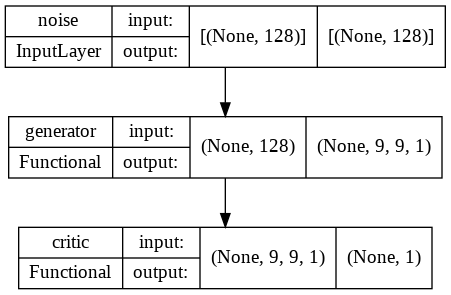

In [13]:
keras.utils.plot_model(generator_training, show_shapes=True)

Our output will be a half batch of fake and a half batch of real samples.
Hene can design the Wasserstein loss as a multiplication between the fake and real samples (set noise = -1 and real = +1).

Averaging over the results will give the desired objective.

In [14]:
import tensorflow.keras.backend as K

def wasserstein_loss(y_true, y_pred):
    """Calculates the Wasserstein loss - critic maximises the distance between its output for real and generated samples.
    To achieve this generated samples have the label -1 and real samples the label 1. Multiplying the outputs by the labels results to the wasserstein loss via the Kantorovich-Rubinstein duality"""
    return K.mean(y_true * y_pred)

generator_training.compile(keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9, decay=0.0), loss=[wasserstein_loss])

### Gradient penalty
To obtain the Wasserstein distance, we have to use the gradient penalty to enforce the Lipschitz constraint.

Therefore, we need to design a layer that samples on straight lines between reals and fakes samples 

In [15]:
BATCH_SIZE = 64

class UniformLineSampler(tf.keras.layers.Layer):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size

    def call(self, inputs, **kwargs):
        weights = K.random_uniform((self.batch_size, 1, 1, 1))
        return(weights * inputs[0]) + ((1 - weights) * inputs[1])

    def compute_output_shape(self, input_shape):
        return input_shape[0]

We design the pipeline of the critic training by inserting generated (use generator + noise directly to circumvent expensive prediction step) and real samples into the sampling layer and additionally feeding generated and real samples into the critic.

In [16]:
make_trainable(critic, True)  # unfreeze the critic during the critic training
make_trainable(g, False)  # freeze the generator during the critic training

g_out = g(g.inputs)
critic_out_fake_samples = critic(g_out)
critic_out_data_samples = critic(critic.inputs)
averaged_batch = UniformLineSampler(BATCH_SIZE)([g_out, critic.inputs[0]])
averaged_batch_out = critic(averaged_batch)

critic_training = keras.models.Model(inputs=[g.inputs, critic.inputs], outputs=[critic_out_fake_samples, critic_out_data_samples, averaged_batch_out])

Let us visualize this "computational graph". The critic outputs will be used for the Wasserstein loss and the UniformLineSampler output for the gradient penalty.

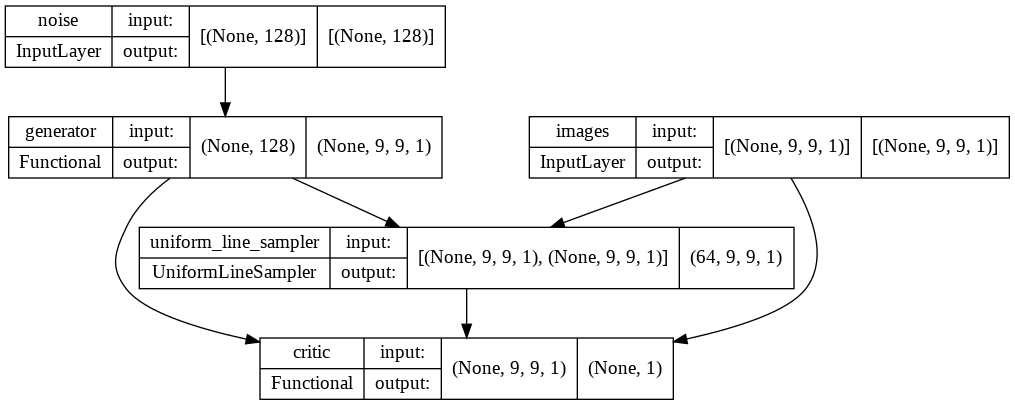

In [17]:
keras.utils.plot_model(critic_training, show_shapes=True)

In [18]:
critic_training.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 noise (InputLayer)             [(None, 128)]        0           []                               
                                                                                                  
 generator (Functional)         (None, 9, 9, 1)      1338625     ['noise[0][0]']                  
                                                                                                  
 images (InputLayer)            [(None, 9, 9, 1)]    0           []                               
                                                                                                  
 uniform_line_sampler (UniformL  (64, 9, 9, 1)       0           ['generator[1][0]',              
 ineSampler)                                                      'images[0][0]']           

We now design the gradient penalty as proposed by in https://arxiv.org/abs/1704.00028

In [19]:
from functools import partial

def gradient_penalty_loss(y_true, y_pred, averaged_batch, penalty_weight):
    """Calculates the gradient penalty.
    The 1-Lipschitz constraint of improved WGANs is enforced by adding a term that penalizes a gradient norm in the critic unequal to 1."""
    gradients = K.gradients(y_pred, averaged_batch)
    gradients_sqr_sum = K.sum(K.square(gradients)[0], axis=(1, 2, 3))
    gradient_penalty = penalty_weight * K.square(1 - K.sqrt(gradients_sqr_sum))
    return K.mean(gradient_penalty)


gradient_penalty = partial(gradient_penalty_loss, averaged_batch=averaged_batch, penalty_weight=10)  # construct the gradient penalty
gradient_penalty.__name__ = 'gradient_penalty'

Let's compile the critic. The losses have to be given in the order as we designed the model outputs (gradient penalty connected to the output of the sampling layer).

In [20]:
critic_training.compile(keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9, decay=0.0), loss=[wasserstein_loss, wasserstein_loss, gradient_penalty])

The labels for the training are (Remember we used as for the Wasserstein loss a simple multiplication to add a sign.)

In [21]:
positive_y = np.ones(BATCH_SIZE)
negative_y = -positive_y
dummy = np.zeros(BATCH_SIZE)  # keras throws an error when calculating a loss without having a label -> needed for using the gradient penalty loss

#### Training
We can now start the training loop.
In the WGAN setup, the critic is trained several times before the generator is updated.

| Task |
|:-------------| 
|Choose a reasonable number of `EPOCHS` until you see a cood convergence.
Choose a meaningful number of `critic_iterations`.|

In [22]:
EPOCHS = 1
critic_iterations = 1

generator_loss = []
critic_loss = []

iterations_per_epoch = nsamples // (critic_iterations * BATCH_SIZE)
iters = 0

for epoch in range(EPOCHS):
    print("epoch: ", epoch)  
    
    for iteration in range(iterations_per_epoch):

        for j in range(critic_iterations):

            noise_batch = np.random.randn(BATCH_SIZE, latent_size)  # generate noise batch for generator
            shower_batch = shower_maps[BATCH_SIZE*(j+iteration):BATCH_SIZE*(j++iteration+1)]  # take batch of shower maps
            critic_loss.append(critic_training.train_on_batch([noise_batch, shower_batch], [negative_y, positive_y, dummy]))  # train the critic

        noise_batch = np.random.randn(BATCH_SIZE, latent_size)  # generate noise batch for generator
        generator_loss.append(generator_training.train_on_batch([noise_batch], [positive_y]))  # train the generator
        iters+=1
        
        generated_maps = g.predict_on_batch(np.random.randn(BATCH_SIZE, latent_size))
        
        if iters % 100 == 1:
            print("iteration", iters)
            print("critic loss:", critic_loss[-1])
            print("generator loss:", generator_loss[-1])

            for i in range(4):
                plt.subplot(2,2,i+1)
                footprint=generated_maps[i,...,0]
                xd, yd = rectangular_array()
                mask = footprint != 0
                mask[5, 5] = True
                marker_size = 50 * footprint[mask]
                plot = plt.scatter(xd, yd, c='grey', s=10, alpha=0.3, label="silent")
                circles = plt.scatter(xd[mask], yd[mask], c=footprint[mask],
                                       s=marker_size, alpha=1, label="loud")
                cbar = plt.colorbar(circles)
                cbar.set_label('signal [a.u.]')
                plt.grid(True)

            plt.suptitle("iteration %i" % iters)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.savefig("./fake_showers_iteration_%.6i.png" % iters)
            plt.close("all")

epoch:  0


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


iteration 1
critic loss: [0.35224676, 1.3326799, -6.164217, 5.183784]
generator loss: -1.2161546
iteration 101
critic loss: [-2.729313, 1.6303959, -4.790117, 0.43040788]
generator loss: -1.6170415
iteration 201
critic loss: [-2.023039, 1.0814722, -3.3725889, 0.26807758]
generator loss: -0.96600044
iteration 301
critic loss: [-1.1981809, 1.1115226, -2.496931, 0.1872276]
generator loss: -1.2179075
iteration 401
critic loss: [0.22258288, 0.8366865, -0.9742879, 0.3601843]
generator loss: -0.5423405
iteration 501
critic loss: [0.8583941, 3.1116307, -2.4256325, 0.17239588]
generator loss: -2.9927893
iteration 601
critic loss: [0.7702265, -1.218159, 1.7479947, 0.2403908]
generator loss: 1.0848875
iteration 701
critic loss: [0.6696876, -0.3927024, 0.57934535, 0.48304465]
generator loss: 0.6107286
iteration 801
critic loss: [0.5572883, 2.5853243, -2.2195363, 0.19150028]
generator loss: -2.5271256
iteration 901
critic loss: [0.49694824, -3.5222154, 3.8817387, 0.13742496]
generator loss: 3.407771

### Results
Let's plot the critic loss.
We now expect to see a convergence of the total loss if the training was successful.

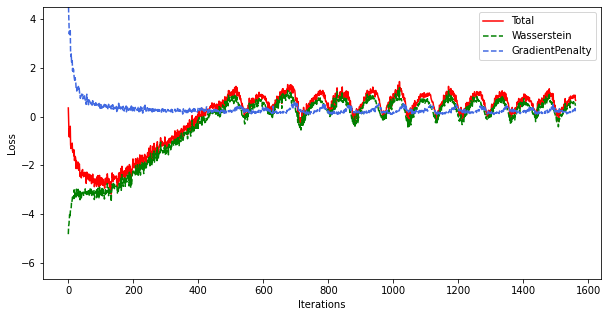

In [23]:
critic_loss = np.array(critic_loss)

plt.subplots(1, figsize=(10, 5))
plt.plot(np.arange(len(critic_loss)), critic_loss[:, 0], color='red', markersize=12, label=r'Total')
plt.plot(np.arange(len(critic_loss)), critic_loss[:, 1] + critic_loss[:, 2], color='green', label=r'Wasserstein', linestyle='dashed')
plt.plot(np.arange(len(critic_loss)), critic_loss[:, 3], color='royalblue', markersize=12, label=r'GradientPenalty', linestyle='dashed')
plt.legend(loc='upper right')
plt.xlabel(r'Iterations')
plt.ylabel(r'Loss')
plt.ylim(np.min(critic_loss)-0.5, 4.5)
plt.show()

In addition, we can visualize the generator loss.

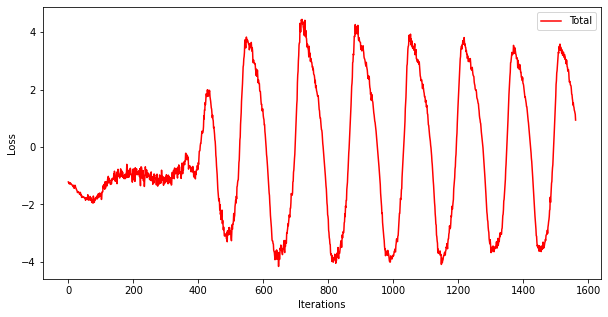

In [24]:
generator_loss = np.array(generator_loss)

plt.subplots(1, figsize=(10, 5))
plt.plot(np.arange(len(generator_loss)), generator_loss, color='red', markersize=12, label=r'Total')
plt.legend(loc='upper right')
plt.xlabel(r'Iterations')
plt.ylabel(r'Loss')
plt.show()

To nicely see the training progress, we can create a gif of the generated samples during the training.

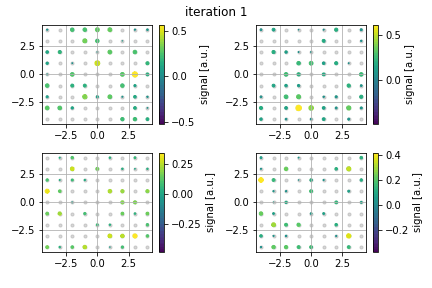

In [25]:
import imageio
import glob

out_file = 'generated_shower_samples.gif'

with imageio.get_writer(out_file, mode='I', duration=0.5) as writer:
    file_names = glob.glob('fake_showers_iteration_*.png')
    file_names = sorted(file_names)
    last = -1

    for i, file_name in enumerate(file_names):
        animated_image = imageio.imread(file_name)
        writer.append_data(animated_image)

    animated_image = imageio.imread(file_name)
    writer.append_data(animated_image)

from IPython.display import Image
Image(open('generated_shower_samples.gif','rb').read())

In [26]:
ls

airshowers.npz                     fake_showers_iteration_000901.png
fake_showers_iteration_000001.png  fake_showers_iteration_001001.png
fake_showers_iteration_000101.png  fake_showers_iteration_001101.png
fake_showers_iteration_000201.png  fake_showers_iteration_001201.png
fake_showers_iteration_000301.png  fake_showers_iteration_001301.png
fake_showers_iteration_000401.png  fake_showers_iteration_001401.png
fake_showers_iteration_000501.png  fake_showers_iteration_001501.png
fake_showers_iteration_000601.png  generated_shower_samples.gif
fake_showers_iteration_000701.png  model.png
fake_showers_iteration_000801.png  sample_data/
